In [1]:
import numpy as np
import awkward as ak

from coffea import processor
from coffea.analysis_tools import PackedSelection

In [2]:
def invariant_mass(obj1, obj2):
    """returns the invariant mass of the system made of 'obj1' and 'obj2'"""
    return np.sqrt(2 * obj1.pt * obj2.pt * (np.cosh(obj1.eta - obj2.eta) - np.cos(obj1.phi - obj2.phi)))

def normalize(val, cut=None):
    """normalize arrays after a cut or selection"""
    if cut is None:
        ar = ak.to_numpy(ak.fill_none(val, np.nan, axis=0))
        return ar
    else:
        ar = ak.to_numpy(ak.fill_none(val[cut], np.nan, axis=0))
        return ar

In [13]:
class VBFProcessor(processor.ProcessorABC):
    def __init__(self, year: int = 2017):
        self.year = year
    
        # variables, cutflow and output dictionaries
        self.variables = {}
        self.cutflow = {}
        self.output = {}
        
    def add_var(self, name: str, var: np.ndarray):
        """adds variable to output dictonary"""
        self.variables[name] = var
            
    def process(self, events):
        dataset = events.metadata['dataset']
        isMC = hasattr(events, "genWeight")
        
        # sum of genweights for MC data
        sumgenweight = ak.sum(events.genWeight) if isMC else None
        if isMC: self.cutflow["sumw"] = sumgenweight
        
        # jets (only the first 4) and missing energy
        jets = ak.pad_none(events.Jet, 4, clip=True)
        met = events.MET
            
        # variables 
        self.add_var("jet_pt", jets.pt)
        self.add_var("jet_eta", jets.eta)
        self.add_var("jet_mass", jets.mass)
        self.add_var("jet_H", ak.sum(jets.pt, axis=1))
        self.add_var("leading_jets_delta_phi", jets[:, 0].delta_phi(jets[:, 1]))
        self.add_var("leading_jets_delta_eta", abs(jets[:, 0].eta - jets[:, 1].eta))
        self.add_var("leading_jets_invariant_mass", invariant_mass(jets[:, 0], jets[:, 1]))
        self.add_var("met_pt", met.pt)
        self.add_var(
            name="min_met_jet_delta_phi", 
            var=ak.min(ak.pad_none(abs(events.Jet.delta_phi(met)), target=4, clip=True), axis=1)
        )
            
        # selections
        selection = PackedSelection()
        baseline = (
            (self.variables["jet_pt"][:, 0] > 30)
            & (self.variables["jet_pt"][:, 1] > 30)
            & (abs(self.variables["jet_eta"][:, 0]) < 5)
            & (abs(self.variables["jet_eta"][:, 1]) < 5)
            & (self.variables["jet_eta"][:, 0] * self.variables["jet_eta"][:, 1] < 0)
            & (self.variables["jet_H"] > 200)
            & (self.variables["met_pt"] > 50)
        )
        selection.add("baseline", baseline)
        selection.add("leading_jets_delta_phi", abs(self.variables["leading_jets_delta_phi"]) > 2.3)
        selection.add("leading_jets_invariant_mass", self.variables["leading_jets_invariant_mass"] > 1000)
        selection.add("min_met_jet_delta_phi", self.variables["min_met_jet_delta_phi"] > 0.5)
        selection.add("leading_jets_delta_eta_highMass", self.variables["leading_jets_delta_eta"] < 2.5)
        selection.add("leading_jets_delta_eta_lowMass", self.variables["leading_jets_delta_eta"] > 2.5)
        
        regions = {
            "high_mass": [
                "baseline", 
                "leading_jets_delta_phi",
                "leading_jets_invariant_mass",
                "min_met_jet_delta_phi",
                "leading_jets_delta_eta_highMass"
            ],
            "low_mass": [
                "baseline", 
                "leading_jets_delta_phi",
                "leading_jets_invariant_mass",
                "min_met_jet_delta_phi",
                "leading_jets_delta_eta_lowMass"
            ],
        }
        
        # initializing the cutflow dictionary
        for region in regions:
            cuts = {f"{cut}": 0 for cut in regions[region]}
            self.cutflow[region] = dict({"all": 0}, **cuts)
        
        for region in regions:
            # output variables
            selections = regions[region]
            cut = selection.all(*selections)
            
            self.output[region] = {
                key: processor.column_accumulator(normalize(val, cut))
                for key, val in self.variables.items()
            }
            
            # cutflow
            allcuts = set([])
            cut = selection.all(*allcuts)
            self.cutflow[region]["all"] = np.sum(cut)
            
            for sel in regions[region]:
                allcuts.add(sel)
                cut = selection.all(*allcuts)
                self.cutflow[region][sel] = np.sum(cut)

        return {
            dataset: {
                "variables": self.output, 
                "cutflow": self.cutflow
            }
        }
    
    def postprocess(self, accumulator):
        for dataset, output in accumulator.items():
            for region in output["variables"]:
                for var in output["variables"][region]:
                    output["variables"][region][var] = ak.from_numpy(output["variables"][region][var].value)
        return accumulator

In [ ]:
import json

with open("/home/cms-jovyan/VBFDM_UdeA/fileset/fileset_2017_UL_NANO.json", "r") as f:
    fileset = json.load(f)
    
nfiles = 1
for key, val in fileset.items():
    fileset[key] = ["root://xcache/" + file for file in val[:nfiles]]

In [14]:
from dask.distributed import Client

client = Client("tls://daniel-2eocampo-2ehenao-40cern-2ech.dask.coffea.casa:8786")
client

<Client: 'tls://192.168.213.29:8786' processes=1 threads=2, memory=7.00 GiB>

In [15]:
out = processor.run_uproot_job(
    fileset,
    treename="Events",
    processor_instance=VBFProcessor(),
    executor=processor.dask_executor,
    executor_args={
        "schema": processor.NanoAODSchema,
        "client": client,
    },
)

In [16]:
out['ST_s-channel_4f_InclusiveDecays_13TeV-amcatnlo-pythia8']["variables"]

{'high_mass': {'jet_pt': <Array [[326, 267, 187, ... 367, 120, 70.5]] type='116 * 4 * ?float32'>,
  'jet_eta': <Array [[1.66, -0.745, ... 0.0167, -1.01]] type='116 * 4 * ?float32'>,
  'jet_mass': <Array [[30.1, 33.8, 37.2, ... 24.7, 8.3]] type='116 * 4 * ?float32'>,
  'jet_H': <Array [888, 1.1e+03, ... 1.2e+03, 1.11e+03] type='116 * float32'>,
  'leading_jets_delta_phi': <Array [2.73, 3.03, -3.04, ... -2.86, -3.02] type='116 * float64'>,
  'leading_jets_delta_eta': <Array [2.41, 1.78, 2.02, ... 1.37, 0.968] type='116 * float64'>,
  'leading_jets_invariant_mass': <Array [1.07e+03, 1.19e+03, ... 1.01e+03] type='116 * float64'>,
  'met_pt': <Array [58.4, 60.9, 62.5, ... 59.8, 55.6, 54.8] type='116 * float32'>,
  'min_met_jet_delta_phi': <Array [0.511, 1.22, 0.904, ... 0.515, 0.94] type='116 * float64'>},
 'low_mass': {'jet_pt': <Array [[280, 241, 110, ... 195, 122, 34.9]] type='188 * 4 * ?float32'>,
  'jet_eta': <Array [[-2.33, 0.434, 3.44, ... 1.35, 3.43]] type='188 * 4 * ?float32'>,
  '

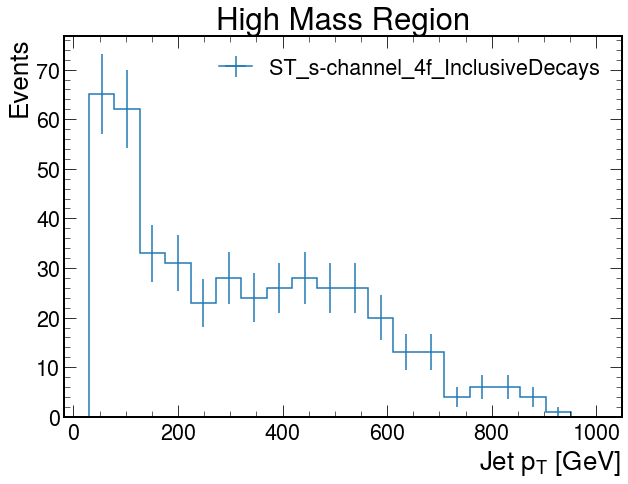

In [49]:
import mplhep as hep
import hist as hist2
import matplotlib.pyplot as plt 
hep.style.use("CMS")

jet_pt_hist = hist2.Hist(
    hist2.axis.StrCategory([], name='region', growth=True),
    hist2.axis.Regular(20, 30, 1000, name="jet_pt", label=r"Jet $p_T$ [GeV]"),
)

jet_pt = out['ST_s-channel_4f_InclusiveDecays_13TeV-amcatnlo-pythia8']["variables"]["high_mass"]["jet_pt"]

jet_pt_hist.fill(
    region="high_mass",
    jet_pt=ak.flatten(jet_pt),
)

fig, ax = plt.subplots(figsize=(10, 7))

hep.histplot(
    jet_pt_hist[{"region":"high_mass"}].project("jet_pt"),
    label="ST_s-channel_4f_InclusiveDecays",
    ax=ax
)

ax.set(
    ylabel="Events",
    title="High Mass Region",
)
ax.legend();

In [19]:
out['ST_s-channel_4f_InclusiveDecays_13TeV-amcatnlo-pythia8']["cutflow"]

{'sumw': 11341370.0,
 'high_mass': {'all': 1117199,
  'baseline': 40935,
  'leading_jets_delta_phi': 29257,
  'leading_jets_invariant_mass': 1116,
  'min_met_jet_delta_phi': 304,
  'leading_jets_delta_eta_highMass': 116},
 'low_mass': {'all': 1117199,
  'baseline': 40935,
  'leading_jets_delta_phi': 29257,
  'leading_jets_invariant_mass': 1116,
  'min_met_jet_delta_phi': 304,
  'leading_jets_delta_eta_lowMass': 188}}

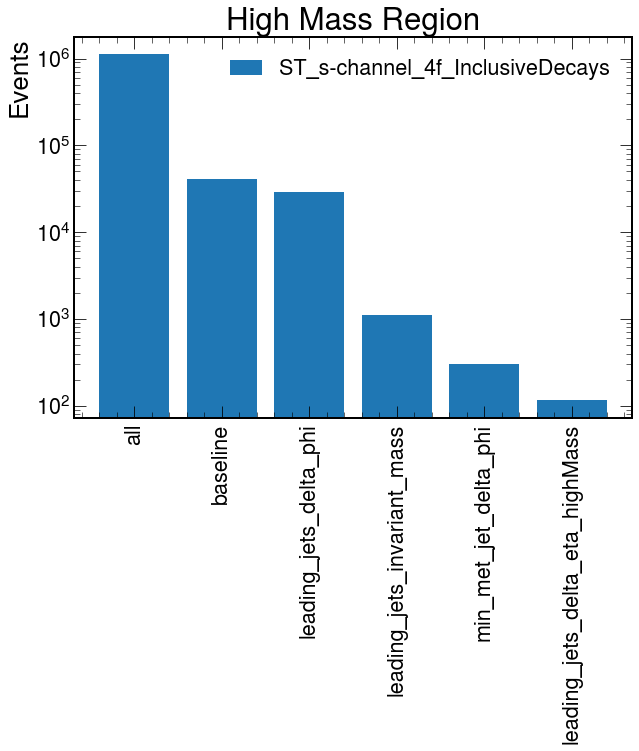

In [50]:
region = "high_mass"
cf = out['ST_s-channel_4f_InclusiveDecays_13TeV-amcatnlo-pythia8']["cutflow"][region]

fig, ax = plt.subplots(figsize=(10, 7))

ax.bar(
    cf.keys(), 
    cf.values(), 
    label="ST_s-channel_4f_InclusiveDecays",
)
ax.set(
    ylabel="Events",
    title="High Mass Region",
    yscale="log",
)

plt.setp(
    ax.xaxis.get_majorticklabels(), 
    rotation=90, 
)
ax.legend();